# IT Asset Lifecycle
- Author: Sanjeev Kumar
- Date: November 2025

Business Problem: Optimize IT asset lifecycle, improve data quality, predict failures, and reduce costs through data-driven insights.


## PART 1: SETUP AND DATA LOADING

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Statistical analysis
from scipy import stats
from scipy.stats import chi2_contingency, f_oneway

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.cluster import KMeans

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("=" * 80)
print("IT ASSET MANAGEMENT ANALYSIS PROJECT")
print("=" * 80)

# Load datasets
print("\n1. Loading datasets...")
df_assets = pd.read_csv(r"C:\Users\snjvm\IT-Asset-Lifecycle\data\it_assets_master.csv")
df_servicenow = pd.read_csv(r"C:\Users\snjvm\IT-Asset-Lifecycle\data\servicenow_discovery.csv")
df_incidents = pd.read_csv(r"C:\Users\snjvm\IT-Asset-Lifecycle\data\incident_history.csv")

print(f"   - Master Assets: {len(df_assets):,} records")
print(f"   - ServiceNow Discovery: {len(df_servicenow):,} records")
print(f"   - Incident History: {len(df_incidents):,} records")


IT ASSET MANAGEMENT ANALYSIS PROJECT

1. Loading datasets...
   - Master Assets: 5,000 records
   - ServiceNow Discovery: 4,280 records
   - Incident History: 3,114 records


## PART 2: DATA QUALITY ANALYSIS

In [5]:

print("\n" + "=" * 80)
print("PART 2: DATA QUALITY ANALYSIS")
print("=" * 80)

def calculate_data_quality_score(df):
    """Calculate comprehensive data quality metrics"""
    
    total_cells = df.shape[0] * df.shape[1]
    
    # Completeness: percentage of non-null values
    completeness = (df.notna().sum().sum() / total_cells) * 100
    
    # Accuracy: check for valid date formats and logical consistency
    accuracy_issues = 0
    if 'Purchase_Date' in df.columns and 'Warranty_End_Date' in df.columns:
        df['Purchase_Date_dt'] = pd.to_datetime(df['Purchase_Date'], errors='coerce')
        df['Warranty_End_Date_dt'] = pd.to_datetime(df['Warranty_End_Date'], errors='coerce')
        accuracy_issues += (df['Warranty_End_Date_dt'] < df['Purchase_Date_dt']).sum()
    
    accuracy = ((df.shape[0] - accuracy_issues) / df.shape[0]) * 100
    
    # Uniqueness: check for duplicates in key fields
    if 'Serial_Number' in df.columns:
        duplicates = df['Serial_Number'].duplicated().sum()
        uniqueness = ((df.shape[0] - duplicates) / df.shape[0]) * 100
    else:
        uniqueness = 100
    
    return {
        'Completeness': round(completeness, 2),
        'Accuracy': round(accuracy, 2),
        'Uniqueness': round(uniqueness, 2),
        'Overall_Score': round((completeness + accuracy + uniqueness) / 3, 2)
    }

# Calculate data quality scores
quality_master = calculate_data_quality_score(df_assets)
print("\nData Quality Assessment - Master Asset Database:")
for metric, score in quality_master.items():
    print(f"   {metric}: {score}%")

# Identify missing data by column
print("\nMissing Data Analysis:")
missing_data = df_assets.isnull().sum()
missing_data = missing_data[missing_data > 0].sort_values(ascending=False)
for col, count in missing_data.items():
    pct = (count / len(df_assets)) * 100
    print(f"   {col}: {count} ({pct:.1f}%)")

# Reconciliation analysis (matching your experience)
print("\nData Reconciliation: Master vs ServiceNow Discovery")
merged_check = df_assets.merge(
    df_servicenow, 
    on='Serial_Number', 
    how='outer', 
    indicator=True
)

reconciliation = merged_check['_merge'].value_counts()
print(f"   - Records in both systems: {reconciliation.get('both', 0):,}")
print(f"   - Only in Master (not discovered): {reconciliation.get('left_only', 0):,}")
print(f"   - Only in ServiceNow (orphan CIs): {reconciliation.get('right_only', 0):,}")

# User assignment discrepancies
if 'both' in reconciliation.index:
    both_systems = merged_check[merged_check['_merge'] == 'both'].copy()
    user_mismatch = (both_systems['Assigned_User'] != both_systems['Discovered_User']).sum()
    print(f"   - User assignment discrepancies: {user_mismatch}")
    
    encryption_mismatch = (both_systems['Encryption_Status'] != both_systems['Discovered_Encryption']).sum()
    print(f"   - Encryption status discrepancies: {encryption_mismatch}")



PART 2: DATA QUALITY ANALYSIS

Data Quality Assessment - Master Asset Database:
   Completeness: 94.18%
   Accuracy: 100.0%
   Uniqueness: 100.0%
   Overall_Score: 98.06%

Missing Data Analysis:
   OS_Version: 2928 (58.6%)
   Encryption_Status: 1961 (39.2%)
   Warranty_End_Date: 396 (7.9%)
   Warranty_End_Date_dt: 396 (7.9%)
   Assigned_User: 248 (5.0%)

Data Reconciliation: Master vs ServiceNow Discovery
   - Records in both systems: 4,280
   - Only in Master (not discovered): 720
   - Only in ServiceNow (orphan CIs): 0
   - User assignment discrepancies: 714
   - Encryption status discrepancies: 1845


## PART 3: EXPLORATORY DATA ANALYSIS (EDA)


PART 3: EXPLORATORY DATA ANALYSIS

Asset Portfolio Summary:
   Total Asset Value: $15,668,352.32
   Average Asset Cost: $3,133.67
   Median Asset Age: 3.5 years

Asset Status Distribution:
Status
Active        3138
Retired        649
In Storage     463
In Repair      396
Disposed       354
Name: count, dtype: int64

Statistical Analysis - Asset Age:
   Mean: 3.44 years
   Median: 3.46 years
   Mode: 1.74 years
   Std Deviation: 1.98 years
   Variance: 3.91
   Range: 6.82 years
   Skewness: -0.01
   Kurtosis: -1.21

✓ EDA visualizations saved as 'eda_visualizations.png'


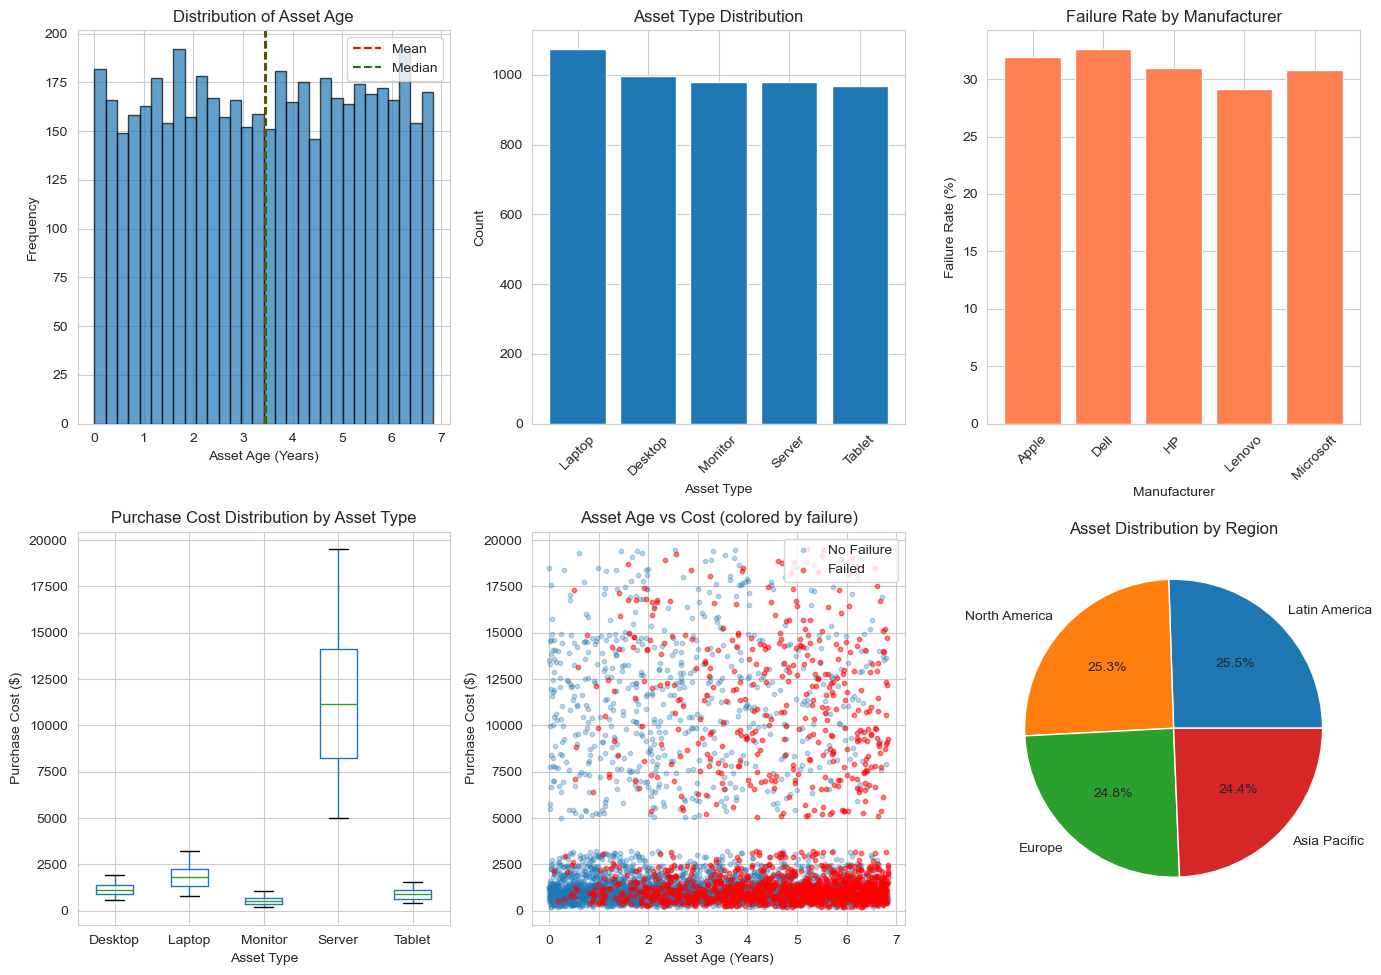

In [25]:
print("\n" + "=" * 80)
print("PART 3: EXPLORATORY DATA ANALYSIS")
print("=" * 80)

# Convert date columns
df_assets['Purchase_Date'] = pd.to_datetime(df_assets['Purchase_Date'])
df_assets['Warranty_End_Date'] = pd.to_datetime(df_assets['Warranty_End_Date'])

# Descriptive statistics
print("\nAsset Portfolio Summary:")
print(f"   Total Asset Value: ${df_assets['Purchase_Cost'].sum():,.2f}")
print(f"   Average Asset Cost: ${df_assets['Purchase_Cost'].mean():,.2f}")
print(f"   Median Asset Age: {df_assets['Age_Years'].median():.1f} years")

# Status distribution
print("\nAsset Status Distribution:")
print(df_assets['Status'].value_counts())

# Measure of Central Tendency and Dispersion (showcasing statistical skills)
print("\nStatistical Analysis - Asset Age:")
print(f"   Mean: {df_assets['Age_Years'].mean():.2f} years")
print(f"   Median: {df_assets['Age_Years'].median():.2f} years")
print(f"   Mode: {df_assets['Age_Years'].mode().values[0]:.2f} years")
print(f"   Std Deviation: {df_assets['Age_Years'].std():.2f} years")
print(f"   Variance: {df_assets['Age_Years'].var():.2f}")
print(f"   Range: {df_assets['Age_Years'].max() - df_assets['Age_Years'].min():.2f} years")

# Skewness and Kurtosis
print(f"   Skewness: {df_assets['Age_Years'].skew():.2f}")
print(f"   Kurtosis: {df_assets['Age_Years'].kurtosis():.2f}")

# Visualization 1: Asset Age Distribution
plt.figure(figsize=(14, 10))

plt.subplot(2, 3, 1)
plt.hist(df_assets['Age_Years'], bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Asset Age (Years)')
plt.ylabel('Frequency')
plt.title('Distribution of Asset Age')
plt.axvline(df_assets['Age_Years'].mean(), color='red', linestyle='--', label='Mean')
plt.axvline(df_assets['Age_Years'].median(), color='green', linestyle='--', label='Median')
plt.legend()

# Visualization 2: Asset Type Distribution
plt.subplot(2, 3, 2)
asset_type_counts = df_assets['Asset_Type'].value_counts()
plt.bar(asset_type_counts.index, asset_type_counts.values)
plt.xlabel('Asset Type')
plt.ylabel('Count')
plt.title('Asset Type Distribution')
plt.xticks(rotation=45)

# Visualization 3: Failure Rate by Manufacturer
plt.subplot(2, 3, 3)
failure_by_mfr = df_assets.groupby('Manufacturer')['Has_Failed'].apply(lambda x: (x == 'Yes').sum() / len(x) * 100)
plt.bar(failure_by_mfr.index, failure_by_mfr.values, color='coral')
plt.xlabel('Manufacturer')
plt.ylabel('Failure Rate (%)')
plt.title('Failure Rate by Manufacturer')
plt.xticks(rotation=45)

# Visualization 4: Cost by Asset Type (Box Plot)
plt.subplot(2, 3, 4)
df_assets.boxplot(column='Purchase_Cost', by='Asset_Type', ax=plt.gca())
plt.xlabel('Asset Type')
plt.ylabel('Purchase Cost ($)')
plt.title('Purchase Cost Distribution by Asset Type')
plt.suptitle('')

# Visualization 5: Age vs Failure (Scatter)
plt.subplot(2, 3, 5)
failed = df_assets[df_assets['Has_Failed'] == 'Yes']
not_failed = df_assets[df_assets['Has_Failed'] == 'No']
plt.scatter(not_failed['Age_Years'], not_failed['Purchase_Cost'], alpha=0.3, label='No Failure', s=10)
plt.scatter(failed['Age_Years'], failed['Purchase_Cost'], alpha=0.5, label='Failed', s=10, color='red')
plt.xlabel('Asset Age (Years)')
plt.ylabel('Purchase Cost ($)')
plt.title('Asset Age vs Cost (colored by failure)')
plt.legend()

# Visualization 6: Region Distribution
plt.subplot(2, 3, 6)
region_counts = df_assets['Region'].value_counts()
plt.pie(region_counts.values, labels=region_counts.index, autopct='%1.1f%%')
plt.title('Asset Distribution by Region')

plt.tight_layout()
plt.savefig('eda_visualizations.png', dpi=300, bbox_inches='tight')
print("\n✓ EDA visualizations saved as 'eda_visualizations.png'")


## PART 4: HYPOTHESIS TESTING

In [28]:
print("\n" + "=" * 80)
print("PART 4: STATISTICAL HYPOTHESIS TESTING")
print("=" * 80)

# Hypothesis 1: Chi-Square Test - Is failure rate independent of manufacturer?
print("\nHypothesis 1: Is failure rate independent of manufacturer?")
print("   H0: Failure rate is independent of manufacturer")
print("   H1: Failure rate depends on manufacturer")

contingency_table = pd.crosstab(df_assets['Manufacturer'], df_assets['Has_Failed'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"   Chi-square statistic: {chi2:.4f}")
print(f"   P-value: {p_value:.4f}")
print(f"   Degrees of freedom: {dof}")

if p_value < 0.05:
    print("   ✓ Reject H0: Failure rate DOES depend on manufacturer (p < 0.05)")
else:
    print("   ✗ Fail to reject H0: No significant relationship found")

# Hypothesis 2: ANOVA - Does average age differ significantly across asset types?
print("\nHypothesis 2: Does average age differ across asset types?")
print("   H0: Mean age is same across all asset types")
print("   H1: At least one asset type has different mean age")

age_groups = [df_assets[df_assets['Asset_Type'] == at]['Age_Years'].values 
              for at in df_assets['Asset_Type'].unique()]
f_stat, p_value_anova = f_oneway(*age_groups)

print(f"   F-statistic: {f_stat:.4f}")
print(f"   P-value: {p_value_anova:.4f}")

if p_value_anova < 0.05:
    print("   ✓ Reject H0: Mean age differs across asset types (p < 0.05)")
else:
    print("   ✗ Fail to reject H0: No significant difference in mean age")

# Hypothesis 3: T-test - Do failed assets have higher average age?
print("\nHypothesis 3: Do failed assets have higher average age?")
print("   H0: Mean age of failed = mean age of non-failed assets")
print("   H1: Mean age of failed ≠ mean age of non-failed assets")

failed_age = df_assets[df_assets['Has_Failed'] == 'Yes']['Age_Years']
not_failed_age = df_assets[df_assets['Has_Failed'] == 'No']['Age_Years']
t_stat, p_value_ttest = stats.ttest_ind(failed_age, not_failed_age)

print(f"   Mean age (failed): {failed_age.mean():.2f} years")
print(f"   Mean age (not failed): {not_failed_age.mean():.2f} years")
print(f"   T-statistic: {t_stat:.4f}")
print(f"   P-value: {p_value_ttest:.4f}")

if p_value_ttest < 0.05:
    print("   ✓ Reject H0: Failed assets have significantly different age (p < 0.05)")
else:
    print("   ✗ Fail to reject H0: No significant age difference")


PART 4: STATISTICAL HYPOTHESIS TESTING

Hypothesis 1: Is failure rate independent of manufacturer?
   H0: Failure rate is independent of manufacturer
   H1: Failure rate depends on manufacturer
   Chi-square statistic: 3.2224
   P-value: 0.5213
   Degrees of freedom: 4
   ✗ Fail to reject H0: No significant relationship found

Hypothesis 2: Does average age differ across asset types?
   H0: Mean age is same across all asset types
   H1: At least one asset type has different mean age
   F-statistic: 1.7419
   P-value: 0.1378
   ✗ Fail to reject H0: No significant difference in mean age

Hypothesis 3: Do failed assets have higher average age?
   H0: Mean age of failed = mean age of non-failed assets
   H1: Mean age of failed ≠ mean age of non-failed assets
   Mean age (failed): 4.58 years
   Mean age (not failed): 2.92 years
   T-statistic: 29.7867
   P-value: 0.0000
   ✓ Reject H0: Failed assets have significantly different age (p < 0.05)


## PART 5: CORRELATION ANALYSIS AND FEATURE ENGINEERING


PART 5: CORRELATION ANALYSIS

✓ Correlation matrix saved as 'correlation_matrix.png'

Correlation with Asset Failure:
   Age_Years: 0.388
   Last_Login_Days_Ago: 0.177
   Status_Encoded: 0.153
   Purchase_Cost: 0.066
   Type_Encoded: 0.003
   Manufacturer_Encoded: -0.018
   Disk_Usage_Percent: -0.135
   Avg_CPU_Usage_Percent: -0.152


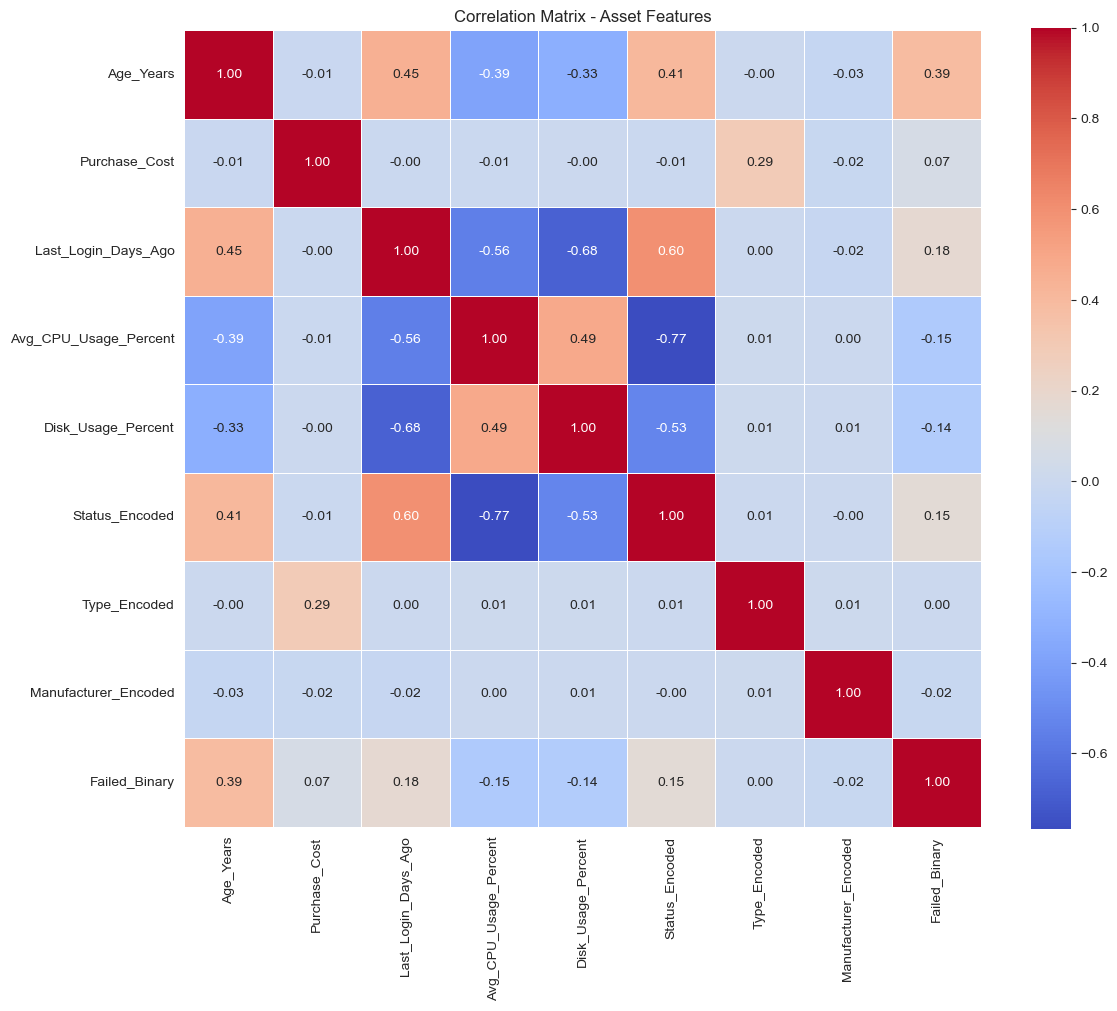

In [35]:
print("\n" + "=" * 80)
print("PART 5: CORRELATION ANALYSIS")
print("=" * 80)

# Prepare numerical features for correlation
df_analysis = df_assets.copy()

# Encode categorical variables
le_status = LabelEncoder()
le_type = LabelEncoder()
le_manufacturer = LabelEncoder()

df_analysis['Status_Encoded'] = le_status.fit_transform(df_analysis['Status'])
df_analysis['Type_Encoded'] = le_type.fit_transform(df_analysis['Asset_Type'])
df_analysis['Manufacturer_Encoded'] = le_manufacturer.fit_transform(df_analysis['Manufacturer'])
df_analysis['Failed_Binary'] = (df_analysis['Has_Failed'] == 'Yes').astype(int)

# Select numerical features
numerical_features = ['Age_Years', 'Purchase_Cost', 'Last_Login_Days_Ago', 
                     'Avg_CPU_Usage_Percent', 'Disk_Usage_Percent', 
                     'Status_Encoded', 'Type_Encoded', 'Manufacturer_Encoded',
                     'Failed_Binary']

correlation_matrix = df_analysis[numerical_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            square=True, linewidths=0.5)
plt.title('Correlation Matrix - Asset Features')
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
print("\n✓ Correlation matrix saved as 'correlation_matrix.png'")

# Print key correlations with failure
print("\nCorrelation with Asset Failure:")
failure_corr = correlation_matrix['Failed_Binary'].sort_values(ascending=False)
for feature, corr in failure_corr.items():
    if feature != 'Failed_Binary':
        print(f"   {feature}: {corr:.3f}")